# Optical Kernel with Linearly Seperable Data

In [34]:
import math
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
import itertools as it
import numpy as np



In [35]:
#number of inputs
N = 4

#Create data 
Nsamples = 1000
Nfeatures=N
centers = 2
random_state = 4
cluster_std = 3
X, Y = make_blobs(n_samples=Nsamples, n_features=Nfeatures,
                  centers=centers,
                  random_state=random_state,
                  cluster_std=cluster_std)

# Make some test data from same specifications 
Ntest = 1000
Xtest, Ytest = make_blobs(n_samples=Ntest, n_features=Nfeatures,
                  centers=centers,
                  random_state=random_state,
                  cluster_std=cluster_std)




In [36]:
#define category groups 
y0 = np.where(Y == 0)
y1 = np.where(Y == 1)

# Classify data points
X_0 = X[y0]
X_1 = X[y1]

#Get Averages 
Xavg0 = np.mean(X_0, axis=0)
Xavg1 = np.mean(X_1, axis=0) 

#Classify test data 
ytest0 = np.where(Ytest == 0)
ytest1 = np.where(Ytest == 1)

X_test_0 = Xtest[ytest0]
X_test_1 = Xtest[ytest1]



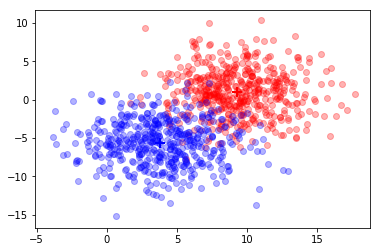

In [37]:
#Plot first two inputs 


# Plot data 
plt.scatter(X_0[:,0], X_0[:,1], color='r', alpha=0.3)
plt.scatter(X_1[:,0], X_1[:,1], color='b', alpha=0.3)

plt.scatter(Xavg0[0], Xavg0[1], color='r', marker='+', s=100, linewidth=2)
plt.scatter(Xavg1[0], Xavg1[1], color='b', marker='+', s=100, linewidth=2)

plt.show()

In [38]:
#Define Maximum Mean discrepancy calculation
def MMD(mean_1, mean_2):
    
    MMD = np.linalg.norm(mean_1 - mean_2)**2
    return MMD

def MMD2(mean_1, mean_2):
    return 2*(1-np.abs(np.dot(mean_1, np.conj(mean_2)))**2)

In [39]:
# Calculating the gradient in the cost function (MMD)
def Grad_SGD(XM0, XM1, wN, wM):
    
    #XM0 is the mean of class0 
    #XM1 is the mean of class 1
    # wN is current weight
    # wM is previous weight

    f0m = np.multiply(wM,XM0)/np.linalg.norm(np.multiply(wM,XM0))
    f1m = np.multiply(wM,XM1)/np.linalg.norm(np.multiply(wM,XM1))
    f0n = np.multiply(wN,XM0)/np.linalg.norm(np.multiply(wN,XM0))
    f1n = np.multiply(wN,XM1)/np.linalg.norm(np.multiply(wN,XM1))
    
    f = np.sqrt(MMD2(f0n, f1n))
    Δf = f - np.sqrt(MMD2(f0m, f1m))
    Δw = wN - wM

    return 2*np.sqrt(f) * (Δf/Δw)



In [40]:
#Define a function to update weight values based on a stochastic gradient decent with momentum

def train_SGD(XM0, XM1, epoch, L, w0, ϵ):
    
    # L is step size
    N = len(XM0)
    
    # Initialise random weights and arrays
    w = np.zeros((epoch, N))
    Cost = np.zeros(epoch)
    w[0] = w0

    w[1] = w[0] + np.random.normal(0, 1, N)*L

    for i in range(1, epoch-1):
        
        XM0cof = np.multiply(w[i-1],XM0)/np.linalg.norm(np.multiply(w[i-1],XM0))
        XM1cof = np.multiply(w[i-1],XM1)/np.linalg.norm(np.multiply(w[i-1],XM1))
        
        Cost[i] = MMD2(XM0cof, XM1cof)
        
        # Compute cost function
        # Cost[i] = MMD(nsphere(XM0, w[i-1]), nsphere(XM1, w[i-1]))
        
        ΔC = Grad_SGD(XM0, XM1, w[i], w[i-1])
        
        if Cost[i] <1.8:
            w[i+1] = w[i] + (ΔC*L) - ϵ*(0.5-np.random.rand( N))
        
        elif 1.8 < Cost[i]:
            w[i+1] = w[i] + (ΔC*0.01*L) - ϵ*(0.5-np.random.rand(N))
    
            
    return w, Cost



In [41]:
#define Hermite Polynomials 
from scipy import special

def Psin(omega, n):
    
    # Get hermite polynomial
    Hn = special.hermite(n)
    
    return np.exp(-omega**2 / 2)/(np.pi**(1/4) * (2**n * factorial(n))**(1/2)) * Hn(omega)

def HOM(t, dt, Dt, psi0, psi1, d):
    
    '''
    t: time array 
    dt: timestep
    Dt: relative time difference between modes
    psi0: coefficients of the first state of dimension d
    psi1: coefficients of the second state of dimension d
    d: dimesnion of subspaces
    '''
    
    Psi1 = np.array([psi0[n]*Psin(t, n) for n in range(d)], dtype=complex)
    Psi2 = np.array([psi1[n]*Psin(t+Dt, n) for n in range(d)], dtype=complex)
    
    prod = np.abs(np.sum(np.conjugate(Psi1)*Psi2)*dt)**2
    
    return 1-prod

Dtvals = np.linspace(-5,5, 500)

In [42]:
# Unit weights
w0 = np.ones(N)
w1 = w0 + np.random.normal(0, 0.0, N)


In [43]:
# Set Learning rate and epochs
L = 0.01
ϵ = L
epoch=500


# Train algorithm
[w, Cost] = train_SGD(Xavg0, Xavg1, epoch, L, w0, ϵ)

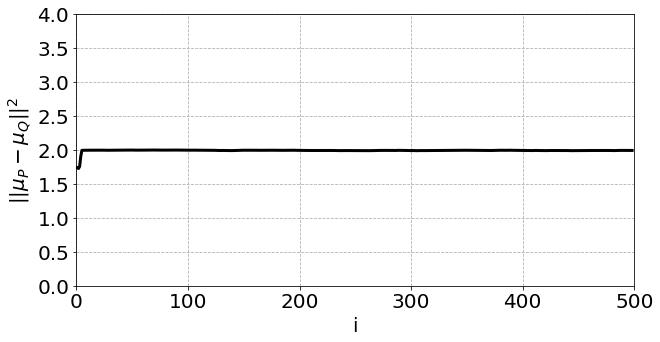

In [44]:
# Plot Cost function
ap = 0.1
sz = 500
fs = 20

epoch_graph = range(1, epoch-1)

plt.figure(figsize=(10,5))
plt.plot(epoch_graph, Cost[1:-1], color='k', linewidth=3)


plt.xlim([0, epoch])

plt.grid(True, linestyle='--')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylabel(r'$|| \mu_{P} - \mu_{Q}||^{2}$', fontsize=fs)
plt.xlabel(r'$\mathrm{i}$', fontsize=fs)

plt.ylim([0,4])

plt.show()

# Visualise Fock State

In [45]:
# Compute coefficients for our states 
X0before = Xavg0/np.linalg.norm(Xavg0).astype(complex)
X0before[N-1] = complex(0,X0before[N-1])
X1before = Xavg1/np.linalg.norm(Xavg1).astype(complex)
X1before[N-1] = complex(0,X1before[N-1])

X0after =np.multiply(w[epoch-1],Xavg0)/np.linalg.norm(np.multiply(w[epoch-1],Xavg0)).astype(complex)
X0after[N-1] = complex(0,X0after[N-1])
X1after =np.multiply(w[epoch-1],Xavg1)/np.linalg.norm(np.multiply(w[epoch-1],Xavg1)).astype(complex)
X1after[N-1] = complex(0,X1after[N-1])




In [46]:
print('Overlap of means before training =', np.round(np.abs(np.dot(X0before, np.conj(X1before)))**2,3))
print('Overlap of means after training =', np.round(np.abs(np.dot(X0after, np.conj(X1after)))**2,3))

Overlap of means before training = 0.132
Overlap of means after training = 0.003


In [47]:
# Demonstration of Fock modes Before and After 
factorial = np.math.factorial

t0 = -10
t1 = -t0
dt = 0.01
t = np.arange(t0, t1, dt)
dt = t[1]-t[0]


#Define Fock modes before training 
P0b = np.sum(np.array([coef*Psin(t, n) for n, coef in enumerate(X0before)], dtype=complex), axis=0)
P1b = np.sum(np.array([coef*Psin(t, n) for n, coef in enumerate(X1before)], dtype=complex), axis=0)

# Define Fock modes after training
P0A = np.sum(np.array([coef*Psin(t, n) for n, coef in enumerate(X0after)], dtype=complex), axis=0)
P1A = np.sum(np.array([coef*Psin(t, n) for n, coef in enumerate(X1after)], dtype=complex), axis=0)

# Compute Overlap 
OB = np.abs(np.sum(P0b*np.conj(P1b))*dt)**2
OA = np.abs(np.sum(P0A*np.conj(P1A))*dt)**2

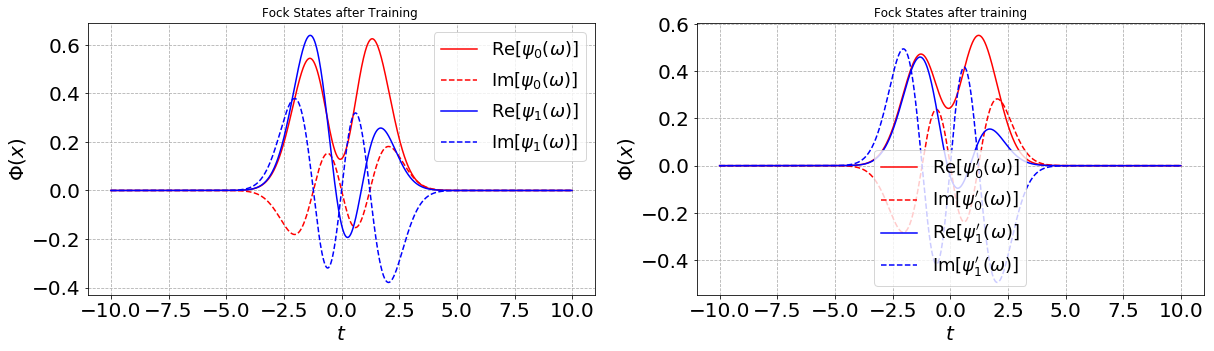

In [48]:
#Plot Fock States before and After training 

fs = 20

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(t, np.real(P0b) ,'r', label=r'$\mathrm{Re}[\psi_{0}(\omega)]$')
plt.plot(t, np.imag(P0b), 'r--',  label=r'$\mathrm{Im}[\psi_{0}(\omega)]$')

plt.plot(t, np.real(P1b) ,'b',  label=r'$\mathrm{Re}[\psi_{1}(\omega)]$')
plt.plot(t, np.imag(P1b), 'b--',  label=r'$\mathrm{Im}[\psi_{1}(\omega)]$')

plt.xlabel(r'$ t$', fontsize=fs)
plt.ylabel(r'$\Phi(x)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=18)
plt.title('Fock States after Training ')
plt.grid(True, linestyle='--')

plt.subplot(1, 2, 2)
plt.plot(t, np.real(P0A) ,'r', label=r"$\mathrm{Re}[\psi_{0}'(\omega)]$")
plt.plot(t, np.imag(P0A), 'r--', label=r"$\mathrm{Im}[\psi_{0}'(\omega)]$")

plt.plot(t, np.real(P1A) ,'b', label=r"$\mathrm{Re}[\psi_{1}'(\omega)]$")
plt.plot(t, np.imag(P1A), 'b--', label=r"$\mathrm{Im}[\psi_{1}'(\omega)]$")

plt.xlabel(r'$ t$', fontsize=fs)
plt.ylabel(r'$\Phi(x)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=18)
plt.title('Fock States after training')
plt.grid(True, linestyle='--')

plt.show()

# Transform Test Data to perform Classification

In [49]:
#All data before
X_0_before=np.zeros(((len(X_test_0)), N),dtype=complex)
for i in range(len(X_test_0)):
    X_0_before[i] = X_test_0[i]/np.linalg.norm(X_test_0[i])
    X_0_before[i,N-1] = complex(0,X_0_before[i,N-1])

X_1_before=np.zeros(((len(X_test_1)), N), dtype=complex)
for i in range(len(X_test_1)):
    X_1_before[i] = X_test_1[i]/np.linalg.norm(X_test_1[i])
    X_1_before[i,N-1] = complex(0,X_1_before[i,N-1])

#All data afterwards 
X_0_after=np.zeros(((len(X_test_0)), N),dtype=complex)
for i in range(len(X_test_0)):
    X_0_after[i] = np.multiply(w[epoch-1],X_test_0[i])/np.linalg.norm(np.multiply(w[epoch-1],X_test_0[i]))
    X_0_after[i,N-1] = complex(0,X_0_after[i,N-1])
    
X_1_after=np.zeros(((len(X_test_1)), N), dtype=complex)
for i in range(len(X_test_1)):
    X_1_after[i] = np.multiply(w[epoch-1],X_test_1[i])/np.linalg.norm(np.multiply(w[epoch-1],X_test_1[i]))
    X_1_after[i,N-1] = complex(0,X_1_after[i,N-1])
    




# Visualise Data Spread 

C:\Users\cassi\Documents\python\lib\site-packages\numpy\core\numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


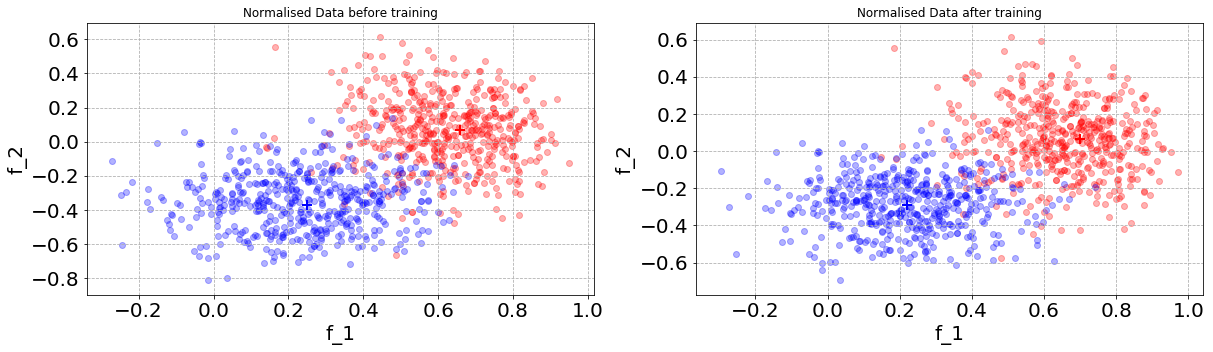

In [50]:
#visualise the data before and after training in two dimensions 

fs = 20

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.scatter(X_0_before[:,0], X_0_before[:,1], color='r', alpha=0.3)
plt.scatter(X_1_before[:,0], X_1_before[:,1], color='b', alpha=0.3)

plt.scatter(X0before[0], X0before[1], color='r', marker='+', s=100, linewidth=2)
plt.scatter(X1before[0], X1before[1], color='b', marker='+', s=100, linewidth=2)


plt.xlabel('f_1', fontsize=fs)
plt.ylabel('f_2', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.title('Normalised Data before training')
plt.grid(True, linestyle='--')

plt.subplot(1, 2, 2)
plt.scatter(X_0_after[:,0], X_0_after[:,1], color='r', alpha=0.3)
plt.scatter(X_1_after[:,0], X_1_after[:,1], color='b', alpha=0.3)

plt.scatter(X0after[0], X0after[1], color='r', marker='+', s=100, linewidth=2)
plt.scatter(X1after[0], X1after[1], color='b', marker='+', s=100, linewidth=2)


plt.xlabel('f_1', fontsize=fs)
plt.ylabel('f_2', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.title('Normalised Data after training')
plt.grid(True, linestyle='--')

plt.show()

# Compute Coincidence counts

In [51]:
# We now go and compute the HOM dip value for each of our ants and bees data point

X0dipB = 1-np.array([np.abs(np.dot(X1before, np.conj(x0)))**2 for x0 in X_0_before])
X1dipB = 1-np.array([np.abs(np.dot(X1before, np.conj(x1)))**2 for x1 in X_1_before])



X0dipA = 1-np.array([np.abs(np.dot(X1after, np.conj(x0)))**2 for x0 in X_0_after])
X1dipA = 1-np.array([np.abs(np.dot(X1after, np.conj(x1)))**2 for x1 in X_1_after])

# CC before
CCb = np.array([HOM(t, dt, Dt, X0before, X1before, N) for Dt in Dtvals])

# CC after
CCa = np.array([HOM(t, dt, Dt, X0after, X1after, N) for Dt in Dtvals])

# Determine Bounds for Classification

In [52]:
#Determine Bounds Before 

boundbmax=1-np.round(np.abs(np.dot(X0before, np.conj(X1before)))**2,3)

#Generate Similarity measures for training data before 
X_1_trainb=np.zeros(((len(X_1)), N), dtype=complex)
for i in range(len(X_1)):
    X_1_trainb[i] = X_1[i]/np.linalg.norm(X_1[i])
    X_1_trainb[i,N-1] = complex(0,X_1_trainb[i,N-1])
    

X1diptrainb = 1-np.array([np.abs(np.dot(X1before, np.conj(x1)))**2 for x1 in X_1_trainb])

boundbmin = np.min(X1diptrainb)

boundb = boundbmax-((boundbmax-boundbmin)/2)

#Determine Bounds After 

boundamax=1-np.round(np.abs(np.dot(X0after, np.conj(X1after)))**2,3)

#Generate Similarity measures for training data after
X_1_traina=np.zeros(((len(X_1)), N), dtype=complex)
for i in range(len(X_1)):
    X_1_traina[i] = np.multiply(w[-1],X_1[i])/np.linalg.norm(np.multiply(w[-1],X_1[i]))
    X_1_traina[i,N-1] = complex(0,X_1_traina[i,N-1])
    

X1diptraina = 1-np.array([np.abs(np.dot(X1after, np.conj(x1)))**2 for x1 in X_1_traina])

boundamin = np.min(X1diptraina)

bounda=boundamax-((boundamax-boundamin)/2)


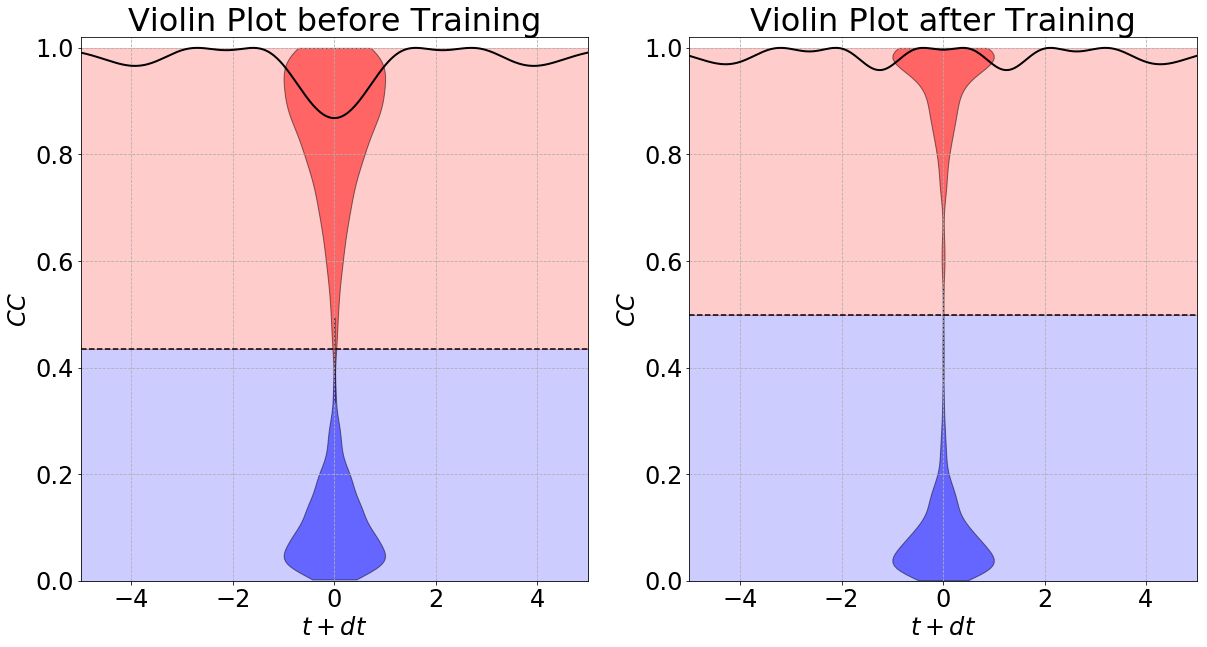

In [53]:
ap = 0.2
sz = 500
fs = 20
wid = 2

# Let's plot the data
plt.figure(figsize=(20,10))

# Subplot 1
plt.subplot(1, 2, 1)

plt.plot(Dtvals, CCb, color='k', linewidth=2)
plt.hlines(boundb ,-5, 5, color='k', linestyle='--')

plt.fill_between(np.linspace(-5, 5, 100), 0, boundb, color='b', alpha=ap)
plt.fill_between(np.linspace(-5, 5, 100), boundb, 1, color='r', alpha=ap)

# Add violin plot
v1 = plt.violinplot(X0dipB, [0], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v1['bodies']:
    pc.set_facecolor('r')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
v2 = plt.violinplot(X1dipB, [0], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v2['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

plt.xlabel(r'$t+dt$', fontsize=24)
plt.ylabel(r'$CC$', fontsize=24)
plt.title(r'Violin Plot before Training', fontsize=32)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim([np.min(Dtvals), np.max(Dtvals)])
plt.ylim([0,1.02])
plt.grid(True, linestyle='--')

plt.subplot(1, 2, 2)

plt.plot(Dtvals, CCa, color='k', linewidth=2)
plt.hlines(bounda ,-5, 5, color='k', linestyle='--')

plt.fill_between(np.linspace(-5, 5, 100), 0, bounda, color='b', alpha=ap)
plt.fill_between(np.linspace(-5, 5, 100), bounda, 1, color='r', alpha=ap)

v1 = plt.violinplot(X0dipA, [0], widths=wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v1['bodies']:
    pc.set_facecolor('r')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
v2 = plt.violinplot(X1dipA, [0], widths= wid, showmeans=False, showmedians=False, showextrema=False)
for pc in v2['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

plt.xlabel(r'$t+dt$', fontsize=24)
plt.ylabel(r'$CC$', fontsize=24)
plt.title(r'Violin Plot after Training', fontsize=32)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.xlim([np.min(Dtvals), np.max(Dtvals)])
plt.ylim([0,1.02])
plt.grid(True, linestyle='--')


plt.show()

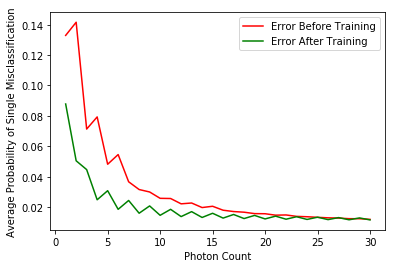

In [57]:
#Calculate average error before and after training 
from scipy.stats import binom


#Create vector of inner product measurements between 0 mean and 0 data before training 
prX00b = np.round(np.abs(np.tensordot(X0before, np.conj(X_0_before),axes=[0,1]))**2,3)

#Create vector of inner product measurements between 0 mean and 0 data after training 
prX00a = np.round(np.abs(np.tensordot(X0after, np.conj(X_0_after),axes=[0,1]))**2,3)

#Create vector of inner product measurements between 0 mean and 1 data before training 
prX01b = np.round(np.abs(np.tensordot(X0before, np.conj(X_1_before),axes=[0,1]))**2,3)

#Create vector of inner product measurements between 0 mean and 1 data after training 
prX01a = np.round(np.abs(np.tensordot(X0after, np.conj(X_1_after),axes=[0,1]))**2,3)

Tmax=31



#Calculate average error at different trial numbers before training 
error_0mean_before = np.zeros(Tmax)
for T in np.arange(1,Tmax):

    #Statistics for measuring 0 against 0 mean before training  
    error_00b = np.zeros(len(X_0_before))
    for i in range(len(X_0_before)):
        error_00b[i]=1-binom.cdf(round(T*boundb),T,1-prX00b[i],loc=0)
    
    #Statistics for measuring 0 mean against 1 data before training 
    error_01b = np.zeros(len(X_1_before))
    for i in range(len(X_1_before)):
        error_01b[i]=binom.cdf(round(T*boundb),T,1-prX01b[i],loc=0)
    
    #average error before training
    error_0mean_before[T] = np.mean(np.concatenate((error_00b, error_01b)))
    

    
#Calculate average error at different trial numbers after training 
error_0mean_after = np.zeros(Tmax)
for T in np.arange(1,Tmax):

    #Statistics for measuring 0 against 0 mean before training  
    error_00a = np.zeros(len(X_0_after))
    for i in range(len(X_0_after)):
        error_00a[i]=1-binom.cdf(round(T*bounda),T,1-prX00a[i],loc=0)
    
    #Statistics for measuring 0 mean against 1 data before training 
    error_01a = np.zeros(len(X_1_after))
    for i in range(len(X_1_after)):
        error_01a[i]=binom.cdf(round(T*bounda),T,1-prX01a[i],loc=0)
    
    #average error before training
    error_0mean_after[T] = np.mean(np.concatenate((error_00a, error_01a)))
    
T=np.arange(0,Tmax)    
plt.plot(T[1:Tmax], error_0mean_before[1:Tmax],'r',label='Error Before Training')
plt.plot(T[1:Tmax], error_0mean_after[1:Tmax],'g',label='Error After Training')
plt.xlabel('Photon Count')
plt.ylabel('Average Probability of Single Misclassification')
plt.legend()
